# Flow rate data interface

Claire and I store flow rate data in slightly different formats. This is a pain in sharing the data, because we have to invoke the data using different methods. In this notebook, I implement methods that mutually convert the data from one form to another. Ideally, the same flow rate data set will be stored in two forms (.csv and .mat), so that each of us can read the data with our own code.

In [1]:
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
from myimagelib.myImageLib import readdata, dirrec
import numpy as np

## 1 Descriptions of the two formats

### 1.1 .mat 

“A_flow_matrice.mat” is a matrice with M lines, M the number of movies, and let’s say N column, N being the minimum number of frames in one movie (although I take 5min movies, sometimes it does not record 601 frames but less…). Each line contain the time sequence of the flow rate in one movie. The matrices are what I use to plot the histogram corresponding to the whole duration of the experiment. Matrice made by Claire have units um^2/sec.

Let's look at an example below.

In [8]:
folder = r"A:\SYMMETRIC\05_july_2022\Flow_rate"
matA = loadmat(os.path.join(folder, "A_flow_matrix.mat"))
matC = loadmat(os.path.join(folder, "C_flow_matrix.mat"))
matA

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Jan 18 18:19:34 2023',
 '__version__': '1.0',
 '__globals__': [],
 'FA': array([[-183.59257993, -184.57180086, -208.81980427, ...,           nan,
                   nan,           nan],
        [ -51.99962246,  -49.28850206,  -45.00556838, ...,           nan,
                   nan,           nan],
        [ -73.33372797,  -76.92642935,  -74.99216905, ...,           nan,
                   nan,           nan],
        ...,
        [ -79.84063745,  -77.32510751,  -83.95530197, ...,           nan,
                   nan,           nan],
        [-162.13035938, -161.36276593, -166.79729253, ...,           nan,
                   nan,           nan],
        [-167.54414665, -157.94303543, -154.26868784, ...,           nan,
                   nan,           nan]])}

Here, apart from the system reserved variables `__xxx__`, we have `FA` left only, which records the flow rate data of each video, at each time step. To access the flow rate data from the first video, it is simply:

(0.0, 500.0)

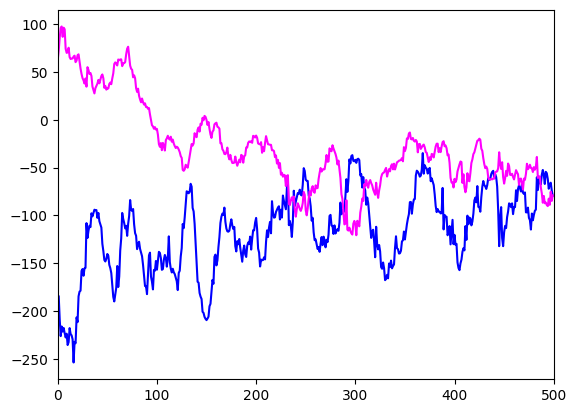

In [10]:
A1 = matA["FA"][0, :]
C1 = matC["FC"][0, :]
plt.plot(A1, color="blue")
plt.plot(C1, color="magenta")
plt.xlim([0, 500])


Compare this plot with the plot in Claire's slides (S2-v1), we know that this is the right way of loading data.

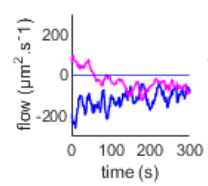

### 1.2 .csv

`xx.csv` is my style of storing flow rate data, where `xx` is the video number of the experiment, identical to the name of the corresponding .nd2 file. Inside the .csv file, there is a (n, 4) table, where n is the number of frames (roughly, 1 frame less than the image due to the nature of PIV which uses image pairs), and 4 is the columns (A, B, C, t). The flow rates are in unit of px^2/frame, and t is in unit of second. Let's look at an example: 

In [43]:
folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
csv = pd.read_csv(os.path.join(folder, "00.csv"))
csv

,A,B,C,t
0,42.440877,186.483955,-124.421915,0.0
1,29.131423,176.581264,-132.562099,0.5
2,26.317650,184.492229,-132.380580,1.0
3,14.003914,193.394960,-134.378371,1.5
4,15.471328,224.868880,-134.207348,2.0
...,...,...,...,...
3594,9.013387,208.365956,-150.335527,1797.0
3595,6.042575,231.694809,-173.169367,1797.5
3596,-5.795403,199.373543,-175.579925,1798.0
3597,-10.113254,163.208218,-166.988136,1798.5


We can plot the data with the following code:

(0.0, 1800.0)

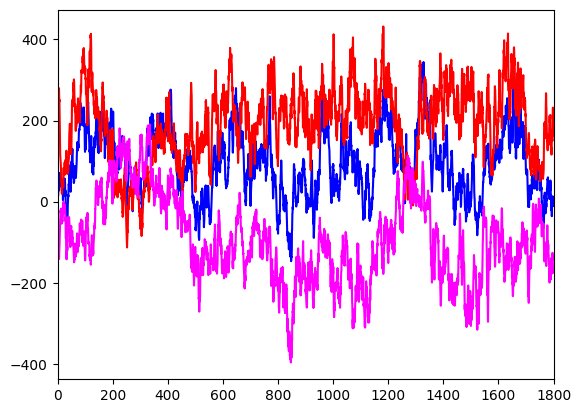

In [13]:
plt.plot(csv.t, csv.A, color="blue")
plt.plot(csv.t, csv.B, color="red")
plt.plot(csv.t, csv.C, color="magenta")
plt.xlim([0, 1800])

## 2 Interface

### 2.1 .mat to .csv

Test script.

In [53]:
folder = r"A:\SYMMETRIC\05_july_2022\Flow_rate"
mark = "_flow_matrix.mat"
l = dirrec(folder, "*{}".format(mark))
mat = {}
csv = {}
for d in l:
    channel_name = os.path.split(d)[1].replace(mark, "") # to get A, B or C
    mat[channel_name] = loadmat(d)["F{}".format(channel_name)]
# initialize DataFrames

for num, fr in enumerate(mat[channel_name]):
    csv[num] = pd.DataFrame()
for channel_name in mat:
    for num, fr in enumerate(mat[channel_name]):
        csv[num][channel_name] = fr
t = np.arange(mat[channel_name].shape[1]) * 0.5
for kw in csv:
    csv[kw]["t"] = t
    csv[kw].to_csv(os.path.join(folder, "{:02d}.csv".format(kw)), index=False)

Wrap in a function and add print messages.

In [3]:
def mat_to_csv(folder, mark="_flow_matrix.mat"):
    """
    Convert flow rate data from .mat format to .csv format.

    folder -- folder of flow rate data
    mark -- common pattern of flow rate data files.
    """
    l = dirrec(folder, "*{}".format(mark))

    # if no files with given mark is found, return to main loop
    if len(l) == 0:
        return 

    mat = {}
    csv = {}

    for d in l:
        channel_name = os.path.split(d)[1].replace(mark, "") # to get A, B or C
        print("Channel {} found".format(channel_name))
        mat[channel_name] = loadmat(d)["F{}".format(channel_name)]
    # initialize DataFrames

    for num, fr in enumerate(mat[channel_name]):
        csv[num] = pd.DataFrame()
    for channel_name in mat:
        for num, fr in enumerate(mat[channel_name]):
            print("Reading {0:02d}_{1} data".format(num, channel_name))
            csv[num][channel_name] = fr
    t = np.arange(mat[channel_name].shape[1]) * 0.5
    print("Saving data to csv ...")
    for kw in csv:
        csv[kw]["t"] = t
        csv[kw].to_csv(os.path.join(folder, "{:02d}.csv".format(kw)), index=False)

In [8]:
flowrate_folder = r"A:\ASYMMETRIC\22_january_2022\Flow_rate"
mat_to_csv(flowrate_folder)

Channel A found
Channel B found
Channel C found
Reading 00_A data
Reading 01_A data
Reading 02_A data
Reading 03_A data
Reading 04_A data
Reading 05_A data
Reading 06_A data
Reading 07_A data
Reading 08_A data
Reading 09_A data
Reading 00_B data
Reading 01_B data
Reading 02_B data
Reading 03_B data
Reading 04_B data
Reading 05_B data
Reading 06_B data
Reading 07_B data
Reading 08_B data
Reading 09_B data
Reading 00_C data
Reading 01_C data
Reading 02_C data
Reading 03_C data
Reading 04_C data
Reading 05_C data
Reading 06_C data
Reading 07_C data
Reading 08_C data
Reading 09_C data
Saving data to csv ...


### 2.2 .csv to .mat

## 3 compact PIV back to .csv

In [2]:
matDir = r"A:\SYMMETRIC\19 jan 2023\nd2\PIV\01_C.mat"
cpiv_dict = loadmat(matDir)

In [9]:
save_folder = r"A:\SYMMETRIC\19 jan 2023\nd2\PIV\01_C"
x = cpiv_dict["x"].flatten()
y = cpiv_dict["y"].flatten()
mask = cpiv_dict["mask"].flatten()
for u, v, label in zip(cpiv_dict["u"], cpiv_dict["v"], cpiv_dict["labels"]):
    pivData = pd.DataFrame({"x": x, "y": y, "u": u.flatten(), "v": v.flatten(), "mask": mask})
    pivData.to_csv(os.path.join(save_folder, "{}.csv".format(label)))